# D2_nn3_tri (2D Linear Triangle) Element
This notebook walks the user through the implementation of 2D linear triangle element. The first few blocks of this notebook are based on [tutorial_discretization.ipynb provided by Prof. Lejeune](https://github.com/Lejeune-Lab-Graduate-Course-Materials/finite-element-analysis/blob/main/tutorials/tutorial_discretization.ipynb).\
In the later blocks, a demonstration is provided by implementing the Poisson Equation.

### Visualising Gauss Points and Element Nodes
The D2_nn3_tri element has 3 nodes given by natural coordinates as (0,0), (1,0) and (0,1) and 1 Gauss point.

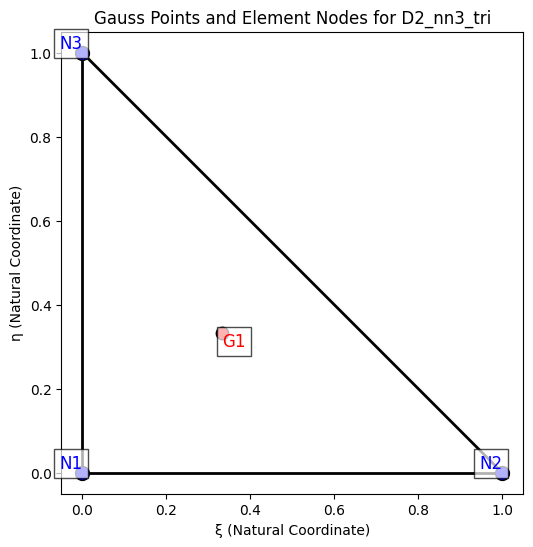

In [1]:
from finiteelementanalysis import discretization_demo_helper_fcns as di_demo

ele_type = "D2_nn3_tri"
num_gauss_pts = 1
fname = "D2_nn3_tri_1gp.png"
di_demo.visualize_gauss_pts(fname, ele_type, num_gauss_pts)

### Visualising interpolated field in the natural coordinates for a given function.

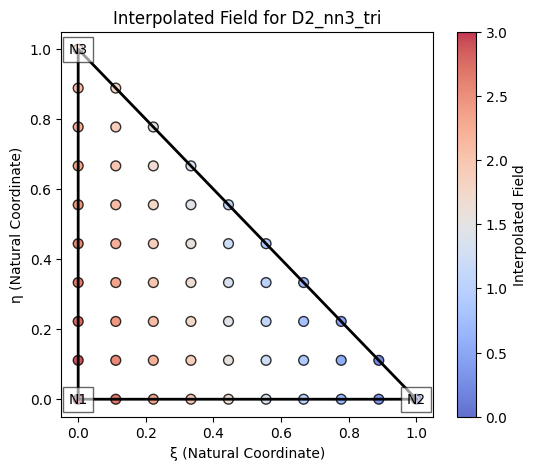

In [2]:
from finiteelementanalysis import discretization_demo_helper_fcns as di_demo
import numpy as np

def fcn(xi, eta):
    return 2.0 * xi + 3.0 * eta

ele_type = "D2_nn3_tri"
node_coords = np.array([[0, 0], [1, 0], [0, 1]])
node_values = np.array([fcn(xi, eta) for xi, eta in node_coords])

fname = ele_type + "_interpolate_fcn.png"
di_demo.plot_interpolate_field_natural_coords_single_element(fname, ele_type, node_values)

### Visualising interpolated field for a given function in natural and physical coordinates

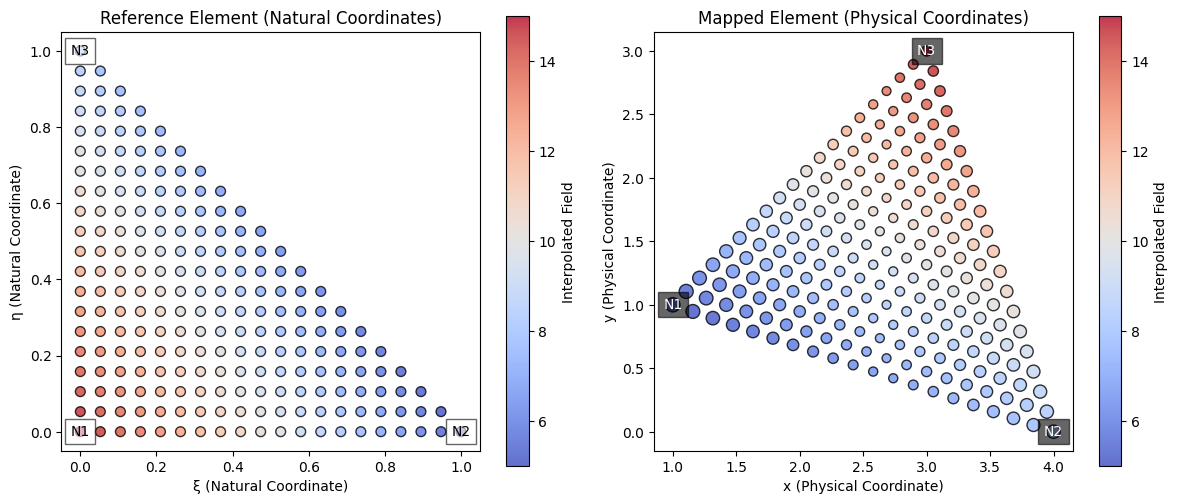

In [3]:
from finiteelementanalysis import discretization_demo_helper_fcns as di_demo
import numpy as np

def fcn(x, y):
    return 2.0 * x + 3.0 * y

ele_type = "D2_nn3_tri"
node_coords = np.array([[1, 1], [4, 0], [3, 3]])
node_values = np.array([fcn(x, y) for x, y in node_coords])
fname = ele_type + "_interpolate_fcn_physical_coords.png"
di_demo.visualize_isoparametric_mapping_single_element(str(fname), ele_type, node_coords, node_values)

### Verifying calculations for derivatives

In [4]:
from finiteelementanalysis import discretization_demo_helper_fcns as di_demo
import numpy as np

def fcn(x, y):
    return 2.0 * x + 3.0 * y

def fcn_deriv(x, y):
    return np.asarray([2.0, 3.0]).reshape((2, 1))

ele_type = "D2_nn3_tri"
node_coords = np.array([[0, 0], [2, 0], [1, 1]])
node_values = np.array([fcn(x, y) for x, y in node_coords])

xi, eta = 1/3, 1/3  # element center in natural coordinates

# Map the test point from natural to physical coordinates
x_mapped = di_demo.interpolate_field_natural_coords_single_element(
    ele_type, node_coords[:, 0], [xi], [eta]
).flatten()[0]
y_mapped = di_demo.interpolate_field_natural_coords_single_element(
    ele_type, node_coords[:, 1], [xi], [eta]
).flatten()[0]

# Evaluate the function derivative in physical coordinates
mapped_deriv = fcn_deriv(x_mapped, y_mapped)

# Compute the numerical gradient in natural coordinates
gradient_natural = di_demo.interpolate_gradient_natural_coords_single_element(
    ele_type, node_values, np.array([xi]), np.array([eta])
)

# Transform the numerical gradient to physical coordinates
gradient_physical = di_demo.transform_gradient_to_physical(
    ele_type, node_coords, np.array([xi]), np.array([eta]), gradient_natural
).reshape((2, 1))
if np.allclose(mapped_deriv, gradient_physical, atol=10e-10):
    print("analytical and numerical derivatives match!")
else:
    print("analytical and numerical derivatives do not match.")

analytical and numerical derivatives match!


### Verifying calculations for integrations 

In [5]:
from finiteelementanalysis import discretization_demo_helper_fcns as di_demo
import numpy as np

def fcn(x, y):
    return 3.0 * x + 10.0 * y

def fcn_deriv(x, y):
    return np.asarray([3.0, 10.0])  # df/dx = 3.0, df/dy = 0

def element_area(node_coords):
    x1, y1 = node_coords[0]
    x2, y2 = node_coords[1]
    x3, y3 = node_coords[2]
    area = 0.5 * abs((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1)) # Area of triangle derived from vector cross product
    return area

def integral_of_deriv(node_coords):
    area = element_area(node_coords)
    return np.array([3.0 * area, 10.0 * area]).reshape((2, 1))

ele_type = "D2_nn3_tri"
num_gauss_pts = 4
node_coords = np.array([[0, 0], [2, 0], [1,1]])

# Compute nodal values from fcn(x, y)
nodal_values = np.array([[fcn(x, y) for x, y in node_coords]]).T

# Compute numerical integral
integral_numerical = di_demo.compute_integral_of_derivative(
    ele_type, num_gauss_pts, node_coords, nodal_values)

# Compute analytical integral
integral_analytical = integral_of_deriv(node_coords)

# check result
if np.allclose(integral_numerical, integral_analytical, atol=10e-10):
    print("analytical and numerical integrals of derivatives match!")
else:
    print("analytical and numerical integrals of derivatives do not match.")

analytical and numerical integrals of derivatives match!


## Poisson Equation
We’ll walk through solving the Poisson equation:
$$\nabla^2u = f\ \ \mathrm{in}\ \Omega$$
with Neumann boundary condition
$$\frac{\partial u}{\partial n} = 0\ \ \mathrm{on}\ \partial\Omega$$
and Dirichlet boundary condition
$$u = 0\ \ \mathrm{at}\ (0, 0)$$
(**Note:** The Neumann boundary condition is implemented implicitly while doing the variational formulation.)\
\
Let's import the required libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from finiteelementanalysis import discretization_demo_helper_fcns as di_demo
from finiteelementanalysis.discretization import element_info, shape_fcn, shape_fcn_derivative

### Defining element type

In [3]:
# Define the element type
element_type = "D2_nn3_tri"

# Retrieve element information
ndim, order, nnodes = element_info(element_type)

print("Element info:")
print(f"- Dimension: {ndim}")
print(f"- Order: {order}")
print(f"- Number of nodes: {nnodes}")

Element info:
- Dimension: 2
- Order: 2
- Number of nodes: 3


### Defining geometry
A square domain with vertices at (0,0), (1,0), (1,1) and (0,1) is taken. It is split into two triangles to work with D2_nn3_tri elements.

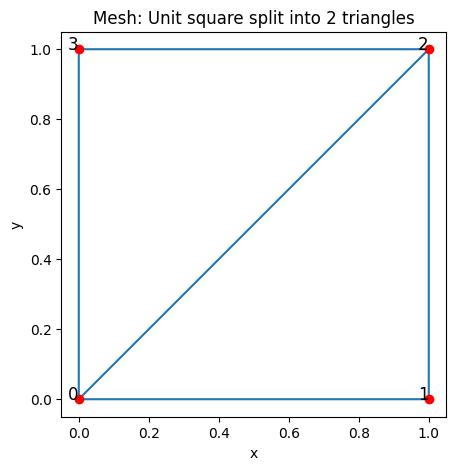

In [4]:
# Node coordinates
nodes = np.array([
    [0.0, 0.0],  # Node 0
    [1.0, 0.0],  # Node 1
    [1.0, 1.0],  # Node 2
    [0.0, 1.0],  # Node 3
])

# Element connectivity
elements = [
    [0, 1, 2],  # Triangle 1
    [0, 2, 3],  # Triangle 2
]

# Plot mesh
plt.figure(figsize=(5, 5))
plt.triplot(nodes[:, 0], nodes[:, 1], elements)
plt.scatter(nodes[:, 0], nodes[:, 1], color='red')
for i, (x, y) in enumerate(nodes):
    plt.text(x, y, f"{i}", fontsize=12, ha="right")
plt.title("Mesh: Unit square split into 2 triangles")
plt.gca().set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Calculation of stiffness matrix
Stiffness matrix is generated for calculating the scalar field $u$. $f = 1$ is considered.

In [5]:
num_nodes = len(nodes)
K = np.zeros((num_nodes, num_nodes))
f = np.zeros(num_nodes)

# Define source function
def source(x, y):
    return 1.0  # Constant right-hand side (f=1)

# Loop over elements
for element in elements:
    node_ids = np.array(element)
    x_e = nodes[node_ids] 

    # Gauss point at centroid
    xi = np.array([1/3, 1/3])
    N = shape_fcn(element_type, xi)
    dN_dxi = shape_fcn_derivative(element_type, xi)

    # Jacobian
    J = dN_dxi.T @ x_e
    detJ = np.linalg.det(J)
    invJ = np.linalg.inv(J)
    dN_dx = dN_dxi @ invJ

    # Element stiffness matrix
    area = 0.5 * abs(detJ)
    ke = area * (dN_dx @ dN_dx.T)

    # Element load vector
    N = shape_fcn(element_type, xi).flatten()
    xq = np.dot(N, x_e)     # mapped Gauss point in physical space
    fq = source(*xq)        # evaluate source at that physical location
    fe = fq * N * area      # multiply by shape function + area

    # Assemble to global system
    for a in range(3):
        A = node_ids[a]
        f[A] += fe[a]
        for b in range(3):
            B = node_ids[b]
            K[A, B] += ke[a, b]

### Boundary condition 
Node at (0, 0) is fixed so that solutions are not of the form $u(x,y) + C$, where $C$ is a constant.

In [6]:
anchor_node = 0 

K_mod = K.copy()
f_mod = f.copy()

K_mod[anchor_node, :] = 0
K_mod[:, anchor_node] = 0
K_mod[anchor_node, anchor_node] = 1.0
f_mod[anchor_node] = 0.0

### Solving the problem

In [7]:
u = np.linalg.solve(K_mod, f_mod)   # Variational equivalent of \nabla^2 u = 1

print("Nodal values of u:")
for i, val in enumerate(u):
    print(f"u[{i}] = {val:.6f}")

Nodal values of u:
u[0] = 0.000000
u[1] = 0.333333
u[2] = 0.555556
u[3] = 0.444444


### Plotting results

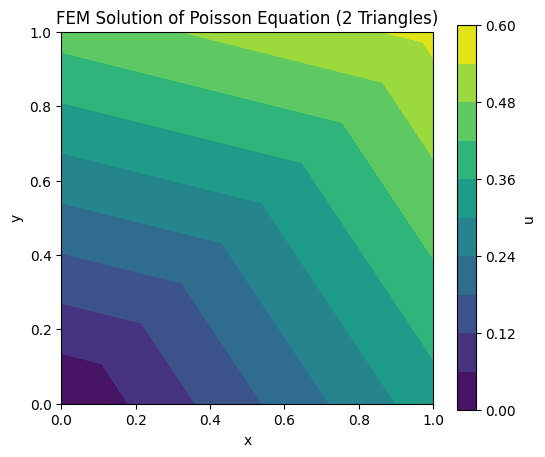

In [8]:
import matplotlib.tri as tri

triang = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

plt.figure(figsize=(6, 5))
plt.tricontourf(triang, u, levels=10, cmap="viridis")
plt.colorbar(label="u")
plt.title("FEM Solution of Poisson Equation (2 Triangles)")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal")
plt.show()